In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


In [2]:
dbunch = get_seutao_dbunch_meta(Meta.df_comb1, np_file, csv_file, bs=128)

loading features
Done loading features


In [3]:
xb,yb = dbunch.one_batch()

In [4]:
[x.shape for x in xb]

[torch.Size([128, 60, 2048]),
 torch.Size([128, 60, 6]),
 torch.Size([128, 60, 1])]

In [5]:
torch.cat(xb, axis=-1).shape

torch.Size([128, 60, 2055])

## Load

In [6]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048+6+1
        hidden = 96
        self.lstm = nn.LSTM(input_size=d_model, hidden_size=hidden, num_layers=2, bidirectional=True, dropout=0.1)
        self.head = nn.Sequential(nn.Linear(hidden*2,6))
        
    def forward(self, x):
        x = torch.cat(x, axis=-1)
        feat, _ = self.lstm(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [7]:
m = SeqHead().cuda()

In [8]:
learn = get_learner(dbunch, m)

In [9]:
name = 'seutao_feat_simple_lstm_meta_fulldataset_20ep'

In [10]:
learn.add_cb(DePadLoss())
# learn.add_cb(SaveModelCallback(name))

## Train

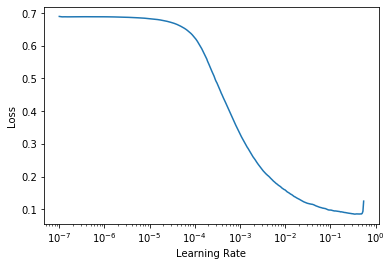

In [15]:
learn.lr_find(num_it=500)

In [12]:
do_fit(learn, 20, 1e-2)
learn.save(f'runs/{name}-1')

Exception ignored in: <function _releaseLock at 0x7f965adbd560>
Traceback (most recent call last):
  File "/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


KeyboardInterrupt: 

In [16]:
do_fit(learn, 14, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.076449,None,None,None,00:16
1,0.064815,None,None,None,00:16
2,0.061881,None,None,None,00:16
3,0.061266,None,None,None,00:16
4,0.061638,None,None,None,00:16
5,0.057114,None,None,None,00:16
6,0.059346,None,None,None,00:16
7,0.056686,None,None,None,00:16
8,0.057957,None,None,None,00:16
9,0.052539,None,None,None,00:16


/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


## Submit

In [11]:
submit_predictions(learn.model, f'runs/{name}-1', f'subm/{name}', 'testing. DISCARD', dfunc=get_seutao_dbunch_meta)

loading features
Done loading features


100%|██████████| 26.0M/26.0M [00:02<00:00, 9.40MB/s]


In [13]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14277000,
 'totalBytes': 27277209,
 'date': '2020-01-23T21:24:01.22Z',
 'description': 'testing. DISCARD',
 'errorDescription': None,
 'fileName': 'seutao_feat_simple_lstm_meta_fulldataset_10ep.csv',
 'publicScore': '0.97097',
 'privateScore': '0.04698',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14277000/14277000.raw'}